# Memetic Algorithm for Text Evolution (MATE)

This is where I code and try out MATE. MATE has been explained significantly in [README.md](README.md). Go through that to know how I plan to use a memetic algorithm to jailbreak our tier-c model :)

## Cell 1: Imports and Setup

In [3]:
# Cell 1: Imports and Setup
import os
import glob
import shutil
import torch
import numpy as np
from pathlib import Path
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from dotenv import load_dotenv
from google import genai
import time
from sentence_transformers import SentenceTransformer
import shap
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import csv

# Setup directories
POPULATION_DIR = Path("population")
EVOLUTION_DIR = Path("evolution")
OFFSPRING_DIR = Path("offspring")
CSV_FILE = Path("evolution.csv")
INPUT_FILE = Path("input.txt")
MODEL_PATH = Path("../task-2/transformer/tier_c_final_model")

print("Directories configured")

/home/samarth/Documents/precog-task/human-or-ai/venv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Directories configured


## Cell 2: Load Classifier Model

In [4]:
# Cell 2: Load Classifier Model
print("Loading classifier model...")

# Load PEFT configuration
peft_model_id = str(MODEL_PATH)
config = PeftConfig.from_pretrained(peft_model_id)

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,  # "distilbert-base-uncased"
    num_labels=3
)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

model = PeftModel.from_pretrained(base_model, peft_model_id)
model.eval()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded on {device}")
print(f"  Base: {config.base_model_name_or_path}")

Loading classifier model...


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 742.97it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded on cpu
  Base: distilbert-base-uncased


## Cell 3: Initialize Gemini API

In [5]:
# Cell 3: Initialize Gemini API
print("Initializing Gemini API...")

# Load API key
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

if not api_key:
    raise ValueError("GEMINI_API_KEY not found in .env file!")

# Initialize client
client = genai.Client(api_key=api_key)
MODEL_NAME = "gemini-pro-latest" 

print(f"Gemini API initialized")
print(f"Model: {MODEL_NAME}")

Initializing Gemini API...
Gemini API initialized
Model: gemini-pro-latest


## Cell 3.5: [DEBUG] Test Gemini API - FIXED

In [6]:
# Cell 3.5: [ DEBUG ] Test Gemini API - FIXED
print("Testing Gemini API with CORRECTED max_output_tokens...")

test_prompt = "Write a short paragraph about technology."

try:
    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=test_prompt,
        config={
            "temperature": 0.7,
            "top_p": 0.95,
            "max_output_tokens": 8192,  # FIXED: Was 512, causing MAX_TOKENS error
        }
    )
    
    print(f"Response received successfully!")
    
    if response.candidates:
        candidate = response.candidates[0]
        print(f"\nFinish reason: {candidate.finish_reason}")
        
        if candidate.content and candidate.content.parts:
            raw_text = candidate.content.parts[0].text
            print(f"\nGenerated text ({len(raw_text)} chars):")
            print(raw_text)
            print("\nAPI is working correctly!")
        else:
            print("ERROR: Still no content/parts")
    else:
        print("ERROR: No candidates in response")
        
except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()


Testing Gemini API with CORRECTED max_output_tokens...
Response received successfully!

Finish reason: FinishReason.STOP

Generated text (695 chars):
Technology has become an inseparable extension of modern human existence, a powerful force that reshapes how we live, work, and connect. At its best, it acts as a great equalizer, democratizing access to information and bridging geographical divides with instantaneous communication. Yet, this same connectivity introduces complex challenges, from navigating issues of privacy and digital well-being to grappling with the rapid pace of change that can leave some behind. Ultimately, technology is a double-edged sword, a tool whose ultimate impact—whether it builds a more inclusive future or deepens existing divisions—is continually shaped by the choices we make in how we create and wield it.

✓ API is working correctly!


## Cell 4: Load Semantic Similarity Model

In [ ]:
# Cell 4: Load Semantic Similarity Model
print("Loading sentence transformer for semantic similarity...")

semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"  Semantic model loaded")
print(f"  Model: all-MiniLM-L6-v2")

Loading sentence transformer for semantic similarity...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 808.48it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Semantic model loaded
  Model: all-MiniLM-L6-v2


## Cell 5: Helper Functions - Classifier Prediction

In [7]:
# Cell 5: Helper Functions - Classifier Prediction
def get_classifier_predictions(text):
    """
    Get classifier predictions for a text.
    Returns: (probs, predicted_class, confidence)
    
    IMPORTANT: Internal model uses 0-indexed classes (0, 1, 2)
    But project uses 1-indexed labels (Class 1, 2, 3):
      - Class 1 (Human)       → probs[0], pred_class=0
      - Class 2 (AI-written)  → probs[1], pred_class=1  
      - Class 3 (AI-mimicry)  → probs[2], pred_class=2
    
    When displaying, add +1: "Class {pred_class+1}"
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    
    predicted_class = np.argmax(probs)
    confidence = probs[predicted_class]
    
    return probs, predicted_class, confidence

def get_human_probability(text):
    """Get P(Human) = P(Class 1) for a text."""
    probs, _, _ = get_classifier_predictions(text)
    return probs[0]

def get_log_human_probability(text):
    """Get log(P(Human)) for better numerical stability when P(Human) is very small."""
    probs, _, _ = get_classifier_predictions(text)
    return np.log(probs[0] + 1e-10)  # Add epsilon to avoid log(0)

# Test on a simple example
test_text = "Technology has become an integral part of modern life."
probs, pred_class, conf = get_classifier_predictions(test_text)
print(f"Test prediction:")
print(f"  P(Human):      {probs[0]:.8f}  [Class 1]")
print(f"  P(AI-written): {probs[1]:.8f}  [Class 2]")
print(f"  P(AI-mimicry): {probs[2]:.8f}  [Class 3]")
print(f"  log(P(Human)): {np.log(probs[0] + 1e-10):.8f}")
print(f"  Predicted: Class {pred_class+1} (internal idx={pred_class}, conf={conf:.4f})")


Test prediction:
  P(Human):      0.00253329  [Class 1]
  P(AI-written): 0.99505049  [Class 2]
  P(AI-mimicry): 0.00241629  [Class 3]
  log(P(Human)): -5.97823811
  Predicted: Class 2 (internal idx=1, conf=0.9951)


## Cell 6: [DEBUG] Helper Functions - Semantic Similarity

In [8]:
# Cell 6: [DEBUG] Helper Functions - Semantic Similarity
def get_semantic_similarity(text1, text2):
    """
    Compute cosine similarity between two texts using sentence embeddings.
    Returns: similarity score in [0, 1]
    """
    embeddings = semantic_model.encode([text1, text2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity

# Test
text1 = "The cat sat on the mat."
text2 = "A feline rested upon the rug."
text3 = "The weather is nice today."

sim_similar = get_semantic_similarity(text1, text2)
sim_different = get_semantic_similarity(text1, text3)

print(f"Semantic similarity test:")
print(f"  Similar texts: {sim_similar:.4f}")
print(f"  Different texts: {sim_different:.4f}")

Semantic similarity test:
  Similar texts: 0.5508
  Different texts: 0.0004


## Cell 7: Helper Functions - Perplexity Estimation

In [9]:
# Cell 7: Helper Functions - Perplexity Estimation
def estimate_perplexity(text):
    """
    Estimate perplexity using the classifier model as a proxy.
    Lower values = more fluent text.
    Note: This is a rough approximation since we don't have a dedicated language model.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        # Use negative log likelihood as proxy
        # Higher confidence = lower perplexity
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        max_prob = torch.max(probs).item()
        
        # Rough perplexity estimate: inverse of confidence
        # This is not true perplexity but serves as fluency indicator
        perplexity = 1.0 / (max_prob + 1e-10)
    
    return perplexity

# Test
fluent_text = "The quick brown fox jumps over the lazy dog."
less_fluent = "The quick brown fox the lazy dog over jumps."

ppl_fluent = estimate_perplexity(fluent_text)
ppl_less = estimate_perplexity(less_fluent)

print(f"Perplexity test:")
print(f"  Fluent text: {ppl_fluent:.4f}")
print(f"  Less fluent: {ppl_less:.4f}")

Perplexity test:
  Fluent text: 1.0804
  Less fluent: 1.5800


## Cell 8: Fitness Function with Lagrangian Relaxation

In [10]:
# Cell 8: Fitness Function with Lagrangian Relaxation
def calculate_fitness(text, original_text, lambda_semantic=2.0, lambda_perplexity=0.5, 
                     semantic_threshold=0.85, perplexity_threshold=2.0):
    """
    Calculate fitness score with Lagrangian relaxation.
    
    Objective: Maximize P(Human) = Minimize P(AI)
    Constraints (soft penalties):
    - Semantic drift beyond threshold
    - Excessive perplexity
    
    Args:
        text: Candidate text
        original_text: Original text for semantic comparison
        lambda_semantic: Penalty weight for semantic drift
        lambda_perplexity: Penalty weight for perplexity
        semantic_threshold: Minimum acceptable similarity (0.85-0.90)
        perplexity_threshold: Maximum acceptable perplexity
    
    Returns:
        fitness: Higher is better
        components: Dict with breakdown
    """
    # Primary objective: maximize P(Human)
    # Use log probabilities to avoid saturation at 0.0000
    p_human = get_human_probability(text)
    log_p_human = get_log_human_probability(text)
    
    # Constraint 1: Semantic similarity
    similarity = get_semantic_similarity(text, original_text)
    semantic_penalty = 0.0
    if similarity < semantic_threshold:
        semantic_penalty = lambda_semantic * (semantic_threshold - similarity)
    
    # Constraint 2: Perplexity
    perplexity = estimate_perplexity(text)
    perplexity_penalty = 0.0
    if perplexity > perplexity_threshold:
        perplexity_penalty = lambda_perplexity * (perplexity - perplexity_threshold)
    
    # Final fitness (higher is better)
    # Use log space to preserve gradient when P(Human) is tiny
    fitness = log_p_human - semantic_penalty - perplexity_penalty
    
    components = {
        'fitness': fitness,
        'p_human': p_human,
        'log_p_human': log_p_human,
        'similarity': similarity,
        'perplexity': perplexity,
        'semantic_penalty': semantic_penalty,
        'perplexity_penalty': perplexity_penalty
    }
    
    return fitness, components

# Test
original = "Technology has become an integral part of modern life."
candidate = "Tech has become a key part of everyday life."

fitness, comp = calculate_fitness(candidate, original)
print(f"Fitness test (HIGH PRECISION):")
print(f"  Fitness: {fitness:.8f}")
print(f"  P(Human): {comp['p_human']:.8f}")
print(f"  log(P(Human)): {comp['log_p_human']:.8f}")
print(f"  Similarity: {comp['similarity']:.4f}")
print(f"  Perplexity: {comp['perplexity']:.4f}")
print(f"  Semantic penalty: {comp['semantic_penalty']:.8f}")
print(f"  Perplexity penalty: {comp['perplexity_penalty']:.8f}")


Fitness test (HIGH PRECISION):
  Fitness: -4.76383018
  P(Human): 0.00941421
  log(P(Human)): -4.66553497
  Similarity: 0.8009
  Perplexity: 1.0135
  Semantic penalty: 0.09829509
  Perplexity penalty: 0.00000000


## Cell 9: SHAP-based Token Saliency

In [11]:
# Cell 9: SHAP-based Token Saliency
def get_token_saliency(text, target_class=1):
    """
    Compute token-level saliency using gradient-based approach.
    
    Args:
        text: Input text
        target_class: Which class to compute saliency for (1=Human, 2=AI-written, 3=AI-mimicry)
    
    Returns:
        tokens: List of tokens
        saliency_scores: Importance score for each token
        top_k_indices: Indices of most important tokens
    """
    model.train()  # Enable gradients
    
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Get embeddings and enable gradients
    embeddings = model.get_base_model().distilbert.embeddings.word_embeddings(input_ids)
    embeddings.requires_grad = True
    
    # Forward pass with custom embeddings
    outputs = model.get_base_model().distilbert(
        inputs_embeds=embeddings,
        attention_mask=attention_mask
    )
    
    # Get logits
    pooled_output = outputs[0][:, 0]  # CLS token
    logits = model.get_base_model().classifier(pooled_output)
    
    # Focus on target class
    target_logit = logits[0, target_class - 1]  # Adjust for 0-indexing
    
    # Backward pass
    target_logit.backward()
    
    # Get gradients
    saliency = embeddings.grad.abs().sum(dim=-1).squeeze().cpu().numpy()
    
    # Convert to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Get top-k indices (excluding special tokens)
    valid_indices = [i for i, tok in enumerate(tokens) 
                    if tok not in ['[CLS]', '[SEP]', '[PAD]']]
    
    # Sort by saliency
    token_saliency = [(i, tokens[i], saliency[i]) for i in valid_indices]
    token_saliency.sort(key=lambda x: x[2], reverse=True)
    
    # Get top 20% indices
    top_k = max(3, len(valid_indices) // 5)
    top_k_indices = [t[0] for t in token_saliency[:top_k]]
    
    model.eval()  # Disable gradients
    
    return tokens, saliency, top_k_indices, token_saliency

# Test
test_text = "Technology has become an integral part of modern life, shaping how we work."
tokens, saliency, top_indices, token_sal = get_token_saliency(test_text)

print(f"Token saliency test:")
print(f"  Total tokens: {len(tokens)}")
print(f"  Top {len(top_indices)} mutable tokens:")
for idx, token, sal in token_sal[:len(top_indices)]:
    print(f"    [{idx}] {token}: {sal:.4f}")

Token saliency test:
  Total tokens: 17
  Top 3 mutable tokens:
    [1] technology: 29.6472
    [5] integral: 25.0190
    [11] shaping: 24.6712


## Cell 10 (REPLACEMENT): Saliency-Guided Mutation

In [25]:
# Cell 10 (REPLACEMENT): Saliency-Guided Mutation
def mutate_with_saliency(text, original_text, top_k_percent=0.15):
    """
    Phase I: Saliency-Based Variable Fixing.
    1. Identify tokens that contribute most to 'AI' classification.
    2. Mask ONLY those tokens.
    3. Ask Gemini to fill the masks with simpler/more human alternatives.
    """
    # 1. Get Saliency
    tokens, saliency, top_indices, _ = get_token_saliency(text, target_class=2) # Target Class 2 (AI) to minimize it
    
    # 2. Create Masked Text
    # Convert list of tokens back to string, replacing top_indices with [MASK]
    token_list = tokens.copy()
    
    # Filter out special tokens ([CLS], [SEP]) from indices
    valid_indices = [i for i in top_indices if token_list[i] not in ['[CLS]', '[SEP]', '[PAD]']]
    
    if not valid_indices:
        return text # No sensitive tokens found
        
    for idx in valid_indices:
        token_list[idx] = "[MASK]"
    
    # Reconstruct text (simple detokenization)
    masked_text = tokenizer.convert_tokens_to_string(token_list)
    
    # 3. Gemini In-filling
    prompt = f"""This paragraph has some words masked out. 
Fill in the [MASK] placeholders with words that make the text sound more CASUAL, HUMAN, and IMPERFECT.
Do NOT use fancy or complex vocabulary. Use simple, everyday words.

Original context: {original_text}
Masked Text: {masked_text}

Output ONLY the completed paragraph:"""
    
    try:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=prompt,
            config={
                "temperature": 1.0,  # High temp for diversity
                "top_p": 0.95,
                "max_output_tokens": 8192,
            }
        )
        if response.candidates and response.candidates[0].content.parts:
            mutated = response.candidates[0].content.parts[0].text.strip()
            # Remove quotes if present
            if mutated.startswith('"') and mutated.endswith('"'):
                mutated = mutated[1:-1]
            return mutated
    except Exception as e:
        print(f"  Mutation failed: {e}")
        
    return text

# Test
test_text = "Technology has become an integral part of modern life."
print("Testing saliency-guided mutation:")
print(f"  Original: {test_text}")
mutated = mutate_with_saliency(test_text, test_text)
print(f"  Mutated:  {mutated}")


Testing saliency-guided mutation:
  Original: Technology has become an integral part of modern life.
  Mutated:  This tech stuff has become a huge part of everyday life.


## Cell 11: Generate Initial Population

In [13]:
# Cell 11: Generate Initial Population
def generate_initial_population(original_text, population_size=10):
    """
    Generate initial population from original text.
    - First individual: original text (copied to population/1.txt)
    - Rest: Gemini-generated variations with high temperature
    
    Args:
        original_text: The source text from input.txt
        population_size: Total population size (default 10)
    
    Returns:
        population: List of text candidates
    """
    print(f"Generating initial population of {population_size}...")
    
    # Clear population directory
    if POPULATION_DIR.exists():
        shutil.rmtree(POPULATION_DIR)
    POPULATION_DIR.mkdir(exist_ok=True)
    
    population = []
    
    # First individual: original text
    population.append(original_text)
    with open(POPULATION_DIR / "1.txt", "w", encoding="utf-8") as f:
        f.write(original_text)
    print(f"  [1/{population_size}] Original text saved")
    
    # Generate variations with high diversity
    prompt_template = """Generate a paragraph that is SIMILAR in meaning to this one, but written differently:

{text}

Requirements:
- Keep the same core message and topic
- Write it in a slightly different style or voice
- Change sentence structure and word choices
- Make it sound natural and fluent
- {words_min}-{words_max} words
- Output ONLY the paragraph, nothing else

New paragraph:"""

    word_count = len(original_text.split())
    words_min = max(50, int(word_count * 0.8))
    words_max = int(word_count * 1.2)
    
    for i in range(2, population_size + 1):
        prompt = prompt_template.format(
            text=original_text,
            words_min=words_min,
            words_max=words_max
        )
        
        try:
            response = client.models.generate_content(
                model=MODEL_NAME,
                contents=prompt,
                config={
                    "temperature": 1.0,  # High diversity
                    "top_p": 0.95,
                    "max_output_tokens": 8192,
                }
            )
            
            if response.candidates and response.candidates[0].content.parts:
                new_text = response.candidates[0].content.parts[0].text.strip()
                # Remove quotes if present
                if new_text.startswith('"') and new_text.endswith('"'):
                    new_text = new_text[1:-1]
                
                population.append(new_text)
                
                # Save to file
                with open(POPULATION_DIR / f"{i}.txt", "w", encoding="utf-8") as f:
                    f.write(new_text)
                
                print(f"  [{i}/{population_size}] Generated variation")
                
                # Rate limiting
                time.sleep(1)
            else:
                # Debug: Show why generation failed
                print(f"  [{i}/{population_size}] Generation failed!")
                if response.candidates:
                    print(f"      Finish reason: {response.candidates[0].finish_reason}")
                    if hasattr(response.candidates[0], 'safety_ratings'):
                        print(f"      Safety ratings: {response.candidates[0].safety_ratings}")
                else:
                    print(f"      No candidates in response")
                print(f"      Using original text instead")
                population.append(original_text)
                
        except Exception as e:
            print(f"  [{i}/{population_size}] Error: {e}, using original")
            population.append(original_text)
            time.sleep(2)
    
    print(f"Initial population generated: {len(population)} individuals")
    return population


## Cell 12: Local Search with Simulated Annealing

In [26]:
# Cell 12: Local Search with Simulated Annealing
def local_search(text, original_text, max_iterations=5, initial_temp=0.1):
    """
    Perform local search on a candidate text.
    Uses simulated annealing to escape local optima.
    Now uses saliency-guided mutations for targeted improvements.
    
    Args:
        text: Current candidate text
        original_text: Original text for fitness calculation
        max_iterations: Number of local search steps
        initial_temp: Initial temperature for simulated annealing
    
    Returns:
        best_text: Improved text
        best_fitness: Fitness of best text
    """
    current_text = text
    current_fitness, _ = calculate_fitness(current_text, original_text)
    best_text = current_text
    best_fitness = current_fitness
    
    for iteration in range(max_iterations):
        # Temperature decay
        temp = initial_temp * (0.8 ** iteration)
        
        # Try saliency-guided mutation
        candidate = mutate_with_saliency(current_text, original_text)
        candidate_fitness, _ = calculate_fitness(candidate, original_text)
        
        # Accept if better, or with probability based on temperature
        delta = candidate_fitness - current_fitness
        if delta > 0 or np.random.random() < np.exp(delta / temp):
            current_text = candidate
            current_fitness = candidate_fitness
            
            # Update best
            if current_fitness > best_fitness:
                best_text = current_text
                best_fitness = current_fitness
        
        # Rate limiting
        time.sleep(0.5)
    
    return best_text, best_fitness


## Cell 13: Evolution Operators

In [27]:
# Cell 13: Evolution Operators
def selection(population, fitnesses, top_k=3):
    """Select top-k individuals."""
    sorted_indices = np.argsort(fitnesses)[::-1]
    selected_indices = sorted_indices[:top_k]
    selected = [population[i] for i in selected_indices]
    selected_fitnesses = [fitnesses[i] for i in selected_indices]
    return selected, selected_fitnesses, selected_indices

def crossover(parent1, parent2):
    """
    Crossover two parents by blending their styles.
    Uses Gemini to create a hybrid.
    """
    prompt = f"""Create a new paragraph that blends the writing style of these two paragraphs while keeping similar meaning:

Paragraph 1:
{parent1}

Paragraph 2:
{parent2}

Requirements:
- Combine stylistic elements from both paragraphs
- Maintain coherent meaning
- Create something that feels like a natural blend
- Output ONLY the blended paragraph

Blended paragraph:""".strip()
    
    try:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=prompt,
            config={
                "temperature": 0.8,
                "top_p": 0.95,
                "max_output_tokens": 8192,
            }
        )
        
        if response.candidates and response.candidates[0].content.parts:
            child = response.candidates[0].content.parts[0].text.strip()
            if child.startswith('"') and child.endswith('"'):
                child = child[1:-1]
            return child
        else:
            return parent1
            
    except Exception as e:
        print(f"  Crossover error: {e}")
        return parent1

def mutate(text, original_text, mutation_rate=0.3):
    """
    Mutate text with given probability using saliency-guided approach.
    Now uses mutate_with_saliency instead of random generic mutations.
    """
    if np.random.random() < mutation_rate:
        return mutate_with_saliency(text, original_text)
    return text

print("Evolution operators defined (now using saliency-guided mutation)")


Evolution operators defined (now using saliency-guided mutation)


## Cell 14: Log Generation to File

In [29]:
# Cell 14: Log Generation to File
def log_generation(generation_num, population, fitnesses, original_text, filepath=None):
    """
    Log generation details to file.
    
    Args:
        generation_num: Generation number
        population: List of candidate texts
        fitnesses: List of fitness scores
        original_text: Original text for reference
        filepath: Optional custom filepath
    """
    if filepath is None:
        filepath = EVOLUTION_DIR / f"evolution_{generation_num}.txt"
    
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(f"GENERATION {generation_num}\n")
        
        # Sort by fitness
        sorted_indices = np.argsort(fitnesses)[::-1]
        
        for rank, idx in enumerate(sorted_indices, 1):
            text = population[idx]
            fitness = fitnesses[idx]
            
            # Get detailed metrics
            _, components = calculate_fitness(text, original_text)
            probs, pred_class, conf = get_classifier_predictions(text)
            
            f.write(f"Rank {rank} | Individual {idx + 1}\n\n")
            f.write(f"Fitness: {fitness:.4f}\n")
            f.write(f"  - P(Human): {components['p_human']:.4f}\n")
            f.write(f"  - P(AI): {probs[1]:.4f}\n")
            f.write(f"  - P(AI-mimicry): {probs[2]:.4f}\n")
            f.write(f"  - Semantic similarity: {components['similarity']:.4f}\n")
            f.write(f"  - Perplexity: {components['perplexity']:.4f}\n")
            f.write(f"  - Predicted class: {pred_class+1} (conf={conf:.4f})\n")
            f.write(f"\nText:\n{text}\n")
            f.write(f"\n{'=' * 80}\n\n")
        
        # Summary statistics
        f.write(f"\nSUMMARY STATISTICS\n")
        f.write(f"Best fitness: {max(fitnesses):.4f}\n")
        f.write(f"Avg fitness:  {np.mean(fitnesses):.4f}\n")
        f.write(f"Worst fitness: {min(fitnesses):.4f}\n")
        f.write(f"Std dev:      {np.std(fitnesses):.4f}\n")
    
    print(f"Logged to {filepath.name}")

print("Logging function defined")

Logging function defined


## Cell 14.5: Offspring and CSV Logging Functions

In [ ]:
# Cell 14.5: Offspring and CSV Logging Functions

def save_offspring(generation, offspring_num, text):
    """Save offspring text to offspring/generation-X_offspring-Y.txt"""
    OFFSPRING_DIR.mkdir(exist_ok=True)
    filepath = OFFSPRING_DIR / f"generation-{generation}_offspring-{offspring_num}.txt"
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(text)

def initialize_csv():
    """Initialize CSV file with headers."""
    with open(CSV_FILE, "w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            'generation', 'individual_id', 'fitness', 'p_human', 'p_ai', 'p_mimicry',
            'log_p_human', 'semantic_similarity', 'perplexity',
            'semantic_penalty', 'perplexity_penalty', 'predicted_class', 'is_best'
        ])

def log_to_csv(generation, population, fitnesses, original_text):
    """Log all individuals in a generation to CSV."""
    best_idx = np.argmax(fitnesses)
    with open(CSV_FILE, "a", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        for i, (text, fitness) in enumerate(zip(population, fitnesses)):
            _, components = calculate_fitness(text, original_text)
            probs, pred_class, _ = get_classifier_predictions(text)
            writer.writerow([
                generation, i+1, f"{fitness:.8f}",
                f"{probs[0]:.8f}", f"{probs[1]:.8f}", f"{probs[2]:.8f}",
                f"{components['log_p_human']:.8f}",
                f"{components['similarity']:.4f}",
                f"{components['perplexity']:.4f}",
                f"{components['semantic_penalty']:.8f}",
                f"{components['perplexity_penalty']:.8f}",
                pred_class+1, 1 if i==best_idx else 0
            ])

print("Offspring and CSV logging functions defined")


✓ Offspring and CSV logging functions defined


## Cell 15: Main MATE Algorithm

In [36]:
# Cell 15: Main MATE Algorithm
def run_mate(original_text, num_generations, population_size=10, top_k_parents=3):
    """
    Run the Memetic Algorithm for Text Evolution (MATE).
    
    Args:
        original_text: Source text to evolve
        num_generations: Number of generations to run
        population_size: Size of population
        top_k_parents: Number of parents to select
    
    Returns:
        best_individual: Best text found
        best_fitness: Fitness of best text
        history: Evolution history
    """
    print("=== MEMETIC ALGORITHM FOR TEXT EVOLUTION (MATE) ===")
    print("  FITNESS IN LOG SPACE - Expect negative values!")
    print("  USING SALIENCY-GUIDED MUTATIONS\n")
    
    # Setup evolution directory
    if EVOLUTION_DIR.exists():
        shutil.rmtree(EVOLUTION_DIR)
    EVOLUTION_DIR.mkdir(exist_ok=True)
    
    # Setup offspring directory (clear old offspring)
    if OFFSPRING_DIR.exists():
        shutil.rmtree(OFFSPRING_DIR)
    OFFSPRING_DIR.mkdir(exist_ok=True)
    
    # Initialize population
    print("\n[STEP 1] Initializing population...")
    population = generate_initial_population(original_text, population_size)
    
    # Evaluate initial population
    print("\n[STEP 2] Evaluating initial population...")
    fitnesses = []
    for i, text in enumerate(population, 1):
        fitness, comp = calculate_fitness(text, original_text)
        fitnesses.append(fitness)
        probs, _, _ = get_classifier_predictions(text)
        # HIGH PRECISION logging to see tiny differences
        print(f"  [{i}/{population_size}] Fitness={fitness:.8f}, P(Human)={probs[0]:.8f}")
        print(f"      ├─ log(P(Human))={comp['log_p_human']:.8f}")
        print(f"      ├─ Semantic penalty={comp['semantic_penalty']:.8f}")
        print(f"      └─ Perplexity penalty={comp['perplexity_penalty']:.8f}")
    
    # Log generation 0
    log_generation(0, population, fitnesses, original_text)
    initialize_csv()
    log_to_csv(0, population, fitnesses, original_text)
    
    # Track best ever
    best_fitness = max(fitnesses)
    best_individual = population[np.argmax(fitnesses)]
    history = []
    
    print(f"\nInitial best fitness: {best_fitness:.8f}")
    
    # Evolution loop
    for gen in range(1, num_generations + 1):
        print(f"\nGENERATION {gen}/{num_generations}")
        
        # Selection
        print("\n[STEP 3] Selection...")
        parents, parent_fitnesses, parent_indices = selection(population, fitnesses, top_k_parents)
        print(f"  Selected top {len(parents)} parents")
        for i, (p_idx, fit) in enumerate(zip(parent_indices, parent_fitnesses), 1):
            probs, _, _ = get_classifier_predictions(parents[i-1])
            _, comp = calculate_fitness(parents[i-1], original_text)
            print(f"    Parent {i} (idx={p_idx+1}): Fitness={fit:.8f}, P(Human)={probs[0]:.8f}")
            print(f"        └─ Components: log(P)={comp['log_p_human']:.6f}, sem_pen={comp['semantic_penalty']:.6f}, ppl_pen={comp['perplexity_penalty']:.6f}")
        
        # Create offspring via crossover and mutation
        print("\n[STEP 4] Crossover & Saliency-Guided Mutation...")
        offspring = []
        
        # Elitism: Keep best parent
        offspring.append(parents[0])
        print(f"  Elitism: Keeping best parent")
        
        # Generate remaining offspring through crossover + saliency-guided mutation
        while len(offspring) < population_size:
            # Select two random parents
            p1, p2 = np.random.choice(len(parents), size=2, replace=False)
            
            # Crossover
            child = crossover(parents[p1], parents[p2])
            time.sleep(1)
            
            # Saliency-guided mutation
            child = mutate(child, original_text, mutation_rate=0.3)
            
            offspring.append(child)
            save_offspring(gen, len(offspring), child)
            print(f"  Generated offspring {len(offspring)}/{population_size}")
            time.sleep(0.5)
        
        # Local search on top 3 offspring (using saliency-guided mutations)
        print("\n[STEP 5] Local search on top offspring (saliency-guided)...")
        offspring_fitnesses = [calculate_fitness(text, original_text)[0] for text in offspring]
        top_offspring_indices = np.argsort(offspring_fitnesses)[::-1][:3]
        
        for i, idx in enumerate(top_offspring_indices, 1):
            print(f"  Local search on offspring {idx+1}...")
            improved_text, improved_fitness = local_search(
                offspring[idx], 
                original_text, 
                max_iterations=3
            )
            offspring[idx] = improved_text
            offspring_fitnesses[idx] = improved_fitness
            print(f"    Fitness: {offspring_fitnesses[idx]:.8f}")
        
        # Replace population
        population = offspring
        fitnesses = offspring_fitnesses
        
        # Update best
        gen_best_fitness = max(fitnesses)
        gen_best_individual = population[np.argmax(fitnesses)]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = gen_best_individual
            print(f"\nNEW BEST FITNESS: {best_fitness:.8f}")
        
        # Log generation
        log_generation(gen, population, fitnesses, original_text)
        log_to_csv(gen, population, fitnesses, original_text)
        
        # Statistics
        history.append({
            'generation': gen,
            'best_fitness': gen_best_fitness,
            'avg_fitness': np.mean(fitnesses),
            'worst_fitness': min(fitnesses),
            'best_p_human': get_human_probability(gen_best_individual)
        })
        
        print(f"\n  Generation {gen} summary (HIGH PRECISION):")
        print(f"    Best fitness:  {gen_best_fitness:.8f}")
        print(f"    Avg fitness:   {np.mean(fitnesses):.8f}")
        print(f"    Worst fitness: {min(fitnesses):.8f}")
        print(f"    Best P(Human): {get_human_probability(gen_best_individual):.8f}")
    
    # Final summary
    print("\n" + "="*60)
    print("EVOLUTION COMPLETE")
    print("="*60)
    print(f"\nBest fitness achieved: {best_fitness:.8f}")
    probs, pred_class, conf = get_classifier_predictions(best_individual)
    print(f"Best individual:")
    print(f"  P(Human): {probs[0]:.8f}")
    print(f"  P(AI): {probs[1]:.8f}")
    print(f"  P(AI-mimicry): {probs[2]:.8f}")
    print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")
    print(f"\nText:\n{best_individual}")
    
    return best_individual, best_fitness, history


## Cell 16: RUN MATE - Configuration

In [34]:
# Cell 16: RUN MATE - Configuration
# Read input text
print("Reading input text...")
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    original_text = f.read().strip()

if not original_text:
    print("WARNING: input.txt is empty!")
    print("Please add your AI-generated paragraph to input.txt and run this cell again.")
else:
    print(f" Input text loaded ({len(original_text.split())} words)")
    print(f"\nOriginal text:")
    print(f"{original_text}")
    
    # Get initial prediction
    probs, pred_class, conf = get_classifier_predictions(original_text)
    print(f"\nInitial classification:")
    print(f"  P(Human): {probs[0]:.4f}")
    print(f"  P(AI): {probs[1]:.4f}")
    print(f"  P(AI-mimicry): {probs[2]:.4f}")
    print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")
    
    # Set number of generations
    num_generations = int(input("\nEnter number of generations to run: "))
    print(f"\nWill run {num_generations} generations")

Reading input text...
 Input text loaded (154 words)

Original text:
The quiet hum of this neighborhood always felt like safety, a soft blanket of routine where the biggest scandal was usually a zoning dispute or an unkempt lawn. I honestly believed I knew the man living in the yellow bungalow across the street. He was the sort of person who returned borrowed tools early and bought Girl Scout cookies by the case, practically invisible in his decency. That illusion shattered the afternoon I accidentally opened his mail, a simple mix-up by the postman. The letter wasn't a utility bill or a birthday card; it was a heavily redacted government dossier with a photo of him looking twenty years younger and terrifyingly cold. Standing there on my porch, holding the envelope that felt suddenly heavy, I realized his gentle demeanor wasn't a personality trait. It was a camouflage, perfect and impenetrable, hiding a history that had no business existing between the library and the bakery.

Initial 

## Cell 17: RUN MATE - Execute Evolution

In [37]:
# Cell 17: RUN MATE - Execute Evolution
# Run MATE algorithm
best_individual, best_fitness, history = run_mate(
    original_text=original_text,
    num_generations=num_generations,
    population_size=10,
    top_k_parents=3
)

# Save best individual
best_file = Path("best_individual.txt")
with open(best_file, "w", encoding="utf-8") as f:
    f.write(f"Best Individual from MATE Evolution\n")
    f.write(f"Fitness: {best_fitness:.4f}\n\n")
    
    probs, pred_class, conf = get_classifier_predictions(best_individual)
    f.write(f"Classification:\n")
    f.write(f"  P(Human): {probs[0]:.4f}\n")
    f.write(f"  P(AI): {probs[1]:.4f}\n")
    f.write(f"  P(AI-mimicry): {probs[2]:.4f}\n")
    f.write(f"  Predicted: Class {pred_class} (conf={conf:.4f})\n\n")
    f.write(f"Text:\n{best_individual}\n")

print(f"\nBest individual saved to {best_file}")

=== MEMETIC ALGORITHM FOR TEXT EVOLUTION (MATE) ===
  FITNESS IN LOG SPACE - Expect negative values!
  USING SALIENCY-GUIDED MUTATIONS


[STEP 1] Initializing population...
Generating initial population of 10...
  [1/10] Original text saved
  [2/10] Generated variation
  [3/10] Generated variation
  [4/10] Generated variation
  [5/10] Generated variation
  [6/10] Generated variation
  [7/10] Generated variation
  [8/10] Generated variation
  [9/10] Generated variation
  [10/10] Generated variation
Initial population generated: 10 individuals

[STEP 2] Evaluating initial population...
  [1/10] Fitness=-14.04408646, P(Human)=0.00000080
      ├─ log(P(Human))=-14.04408646
      ├─ Semantic penalty=0.00000000
      └─ Perplexity penalty=0.00000000
  [2/10] Fitness=-14.33395672, P(Human)=0.00000078
      ├─ log(P(Human))=-14.06084156
      ├─ Semantic penalty=0.27311516
      └─ Perplexity penalty=0.00000000
  [3/10] Fitness=-14.55582428, P(Human)=0.00000057
      ├─ log(P(Human))=-14.38003

KeyboardInterrupt: 

## Cell 17 Results

**NOTE:** In consideration of time, I purposely stopped it after 25 iterations rather than letting it run for a full 50 iterations.  
Looking at the [logs](evolution.csv) from gen 19 to 24, we see that the best-fitness remains at exactly -0.57323194. And for this, highest P(Human)=0.77718425, or `Human with confidence of 77.7%`

The results of cell 17 are all in [results/](results/). The results of this specific run is in [results/6-saliency-based-pruning](results/6-saliency-based-pruning.md).

Do check them out please. I have reported my findings there in detail

## Cell 18: Visualize Evolution Progress

Loading evolution data from CSV...
Available columns: ['generation', 'individual_id', 'fitness', 'p_human', 'p_ai', 'p_mimicry', 'log_p_human', 'semantic_similarity', 'perplexity', 'semantic_penalty', 'perplexity_penalty', 'predicted_class', 'is_best']
Loaded 25 generations from CSV


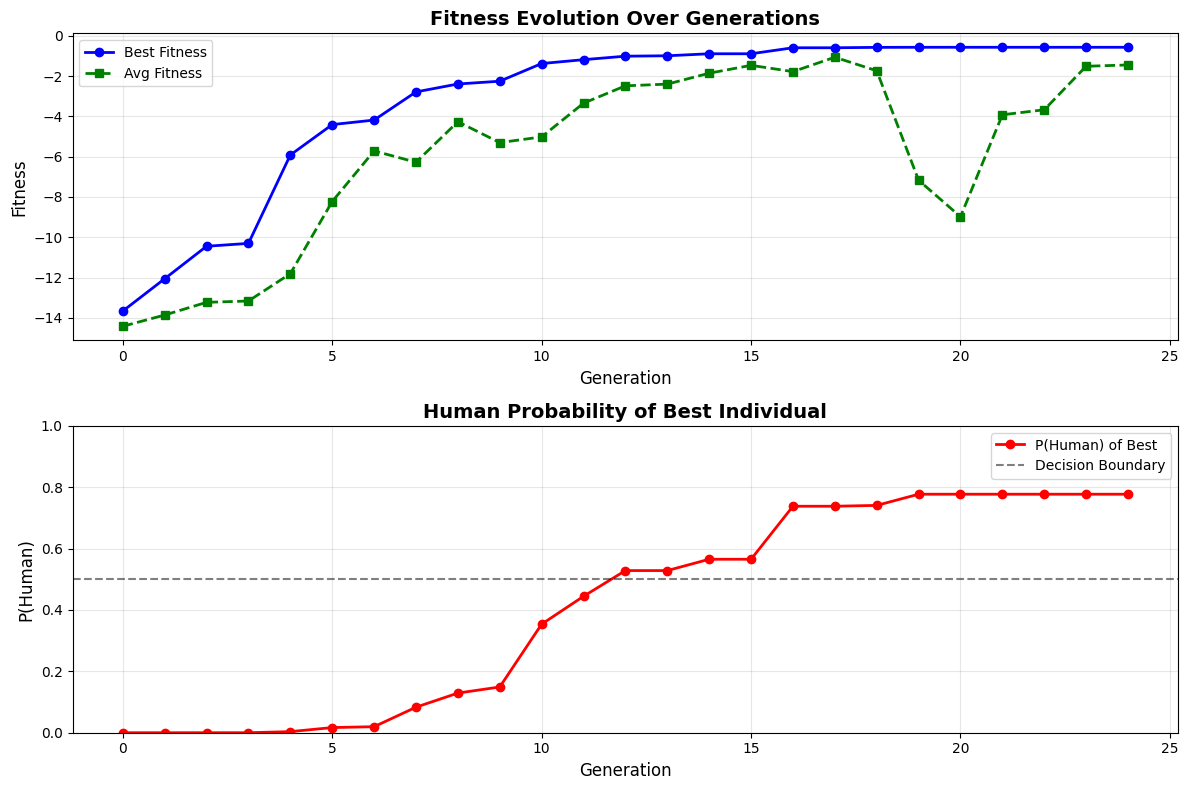

Visualization saved to mate_evolution.png


In [41]:
# Cell 18: Visualize Evolution Progress
import matplotlib.pyplot as plt
import pandas as pd

# Check if history exists from current run, otherwise load from CSV
if 'history' not in globals() or not history:
    print("Loading evolution data from CSV...")
    try:
        df = pd.read_csv(CSV_FILE)
        
        # Debug: show available columns
        print(f"Available columns: {list(df.columns)}")
        
        # Check if required columns exist
        if 'fitness' not in df.columns or 'p_human' not in df.columns:
            print(f"ERROR: Expected columns 'fitness' and 'p_human' not found in CSV")
            history = []
        else:
            # Aggregate by generation to get best/avg fitness
            gen_stats = df.groupby('generation').agg({
                'fitness': ['max', 'mean'],
                'p_human': 'max'
            }).reset_index()
            
            # Flatten column names
            gen_stats.columns = ['generation', 'best_fitness', 'avg_fitness', 'best_p_human']
            
            history = [
                {
                    'generation': int(row['generation']),
                    'best_fitness': float(row['best_fitness']),
                    'avg_fitness': float(row['avg_fitness']),
                    'best_p_human': float(row['best_p_human'])
                }
                for _, row in gen_stats.iterrows()
            ]
            print(f"Loaded {len(history)} generations from CSV")
    except FileNotFoundError:
        print(f"ERROR: {CSV_FILE} not found. Please run Cell 17 first.")
        history = []
    except Exception as e:
        print(f"ERROR loading CSV: {e}")
        import traceback
        traceback.print_exc()
        history = []

if not history:
    print("No evolution data available. Run Cell 17 to generate data.")
else:
    # Plot fitness evolution
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Best and average fitness over generations
    generations = [h['generation'] for h in history]
    best_fitnesses = [h['best_fitness'] for h in history]
    avg_fitnesses = [h['avg_fitness'] for h in history]
    
    axes[0].plot(generations, best_fitnesses, 'b-o', label='Best Fitness', linewidth=2)
    axes[0].plot(generations, avg_fitnesses, 'g--s', label='Avg Fitness', linewidth=2)
    axes[0].set_xlabel('Generation', fontsize=12)
    axes[0].set_ylabel('Fitness', fontsize=12)
    axes[0].set_title('Fitness Evolution Over Generations', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: P(Human) probability over generations
    p_humans = [h['best_p_human'] for h in history]
    axes[1].plot(generations, p_humans, 'r-o', label='P(Human) of Best', linewidth=2)
    axes[1].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Decision Boundary')
    axes[1].set_xlabel('Generation', fontsize=12)
    axes[1].set_ylabel('P(Human)', fontsize=12)
    axes[1].set_title('Human Probability of Best Individual', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('mate_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization saved to mate_evolution.png")


## Cell 19: Compare Original vs Best

In [43]:
# Cell 19: Compare Original vs Best
print("COMPARISON: ORIGINAL vs BEST EVOLVED")

# Load original text if not defined
if 'original_text' not in globals():
    print("Loading original text from input.txt...")
    try:
        with open(INPUT_FILE, "r", encoding="utf-8") as f:
            original_text = f.read().strip()
    except FileNotFoundError:
        print(f"ERROR: {INPUT_FILE} not found")
        original_text = None

# Load best individual if not defined
if 'best_individual' not in globals():
    print("Loading best individual from evolution logs...")
    try:
        # Find the highest numbered evolution file
        evolution_files = list(EVOLUTION_DIR.glob("evolution_*.txt"))
        if not evolution_files:
            print(f"ERROR: No evolution files found in {EVOLUTION_DIR}")
            best_individual = None
        else:
            # Sort by generation number
            evolution_files.sort(key=lambda x: int(x.stem.split('_')[1]))
            latest_file = evolution_files[-1]
            print(f"  Loading from {latest_file.name}")
            
            # Parse the file to extract Rank 1 individual
            with open(latest_file, "r", encoding="utf-8") as f:
                content = f.read()
            
            # Find the first "Text:" section (which is Rank 1)
            text_marker = "\nText:\n"
            if text_marker in content:
                start_idx = content.index(text_marker) + len(text_marker)
                # Find the end (next "=" line or end of file)
                end_marker = "\n=========="
                if end_marker in content[start_idx:]:
                    end_idx = content.index(end_marker, start_idx)
                    best_individual = content[start_idx:end_idx].strip()
                else:
                    best_individual = content[start_idx:].strip()
                print(f"  Best individual loaded ({len(best_individual)} chars)")
            else:
                print("ERROR: Could not find 'Text:' marker in evolution file")
                best_individual = None
    except Exception as e:
        print(f"ERROR loading best individual: {e}")
        import traceback
        traceback.print_exc()
        best_individual = None

# Check if we have the required data
if original_text is None or best_individual is None:
    print("\nERROR: Cannot compare - missing data. Please run Cell 17 first.")
else:
    print("\n[ORIGINAL TEXT]")
    print(original_text)
    print()

    probs_orig, pred_orig, conf_orig = get_classifier_predictions(original_text)
    print(f"Classification:")
    print(f"  P(Human): {probs_orig[0]:.4f}")
    print(f"  P(AI): {probs_orig[1]:.4f}")
    print(f"  P(AI-mimicry): {probs_orig[2]:.4f}")
    print(f"  Predicted: Class {pred_orig+1} (conf={conf_orig:.4f})")

    print("\n[BEST EVOLVED TEXT]")
    print(best_individual)
    print()

    probs_best, pred_best, conf_best = get_classifier_predictions(best_individual)
    print(f"Classification:")
    print(f"  P(Human): {probs_best[0]:.4f}")
    print(f"  P(AI): {probs_best[1]:.4f}")
    print(f"  P(AI-mimicry): {probs_best[2]:.4f}")
    print(f"  Predicted: Class {pred_best+1} (conf={conf_best:.4f})")

    print("\n[IMPROVEMENTS]")
    print(f"P(Human) change: {probs_orig[0]:.4f} → {probs_best[0]:.4f} (+{probs_best[0] - probs_orig[0]:.4f})")
    print(f"P(AI) change: {probs_orig[1]:.4f} → {probs_best[1]:.4f} ({probs_best[1] - probs_orig[1]:.4f})")
    print(f"Semantic similarity: {get_semantic_similarity(original_text, best_individual):.4f}")

    if pred_best == 0:
        print("\nSUCCESS: Best individual is classified as HUMAN (Class 1)!")
    else:
        print(f"\nStill classified as Class {pred_best+1}, but P(Human) improved by {(probs_best[0] - probs_orig[0]) * 100:.2f}%")


COMPARISON: ORIGINAL vs BEST EVOLVED
Loading best individual from evolution logs...
  Loading from evolution_24.txt
  Best individual loaded (1734 chars)

[ORIGINAL TEXT]
The quiet hum of this neighborhood always felt like safety, a soft blanket of routine where the biggest scandal was usually a zoning dispute or an unkempt lawn. I honestly believed I knew the man living in the yellow bungalow across the street. He was the sort of person who returned borrowed tools early and bought Girl Scout cookies by the case, practically invisible in his decency. That illusion shattered the afternoon I accidentally opened his mail, a simple mix-up by the postman. The letter wasn't a utility bill or a birthday card; it was a heavily redacted government dossier with a photo of him looking twenty years younger and terrifyingly cold. Standing there on my porch, holding the envelope that felt suddenly heavy, I realized his gentle demeanor wasn't a personality trait. It was a camouflage, perfect and impe

I do a more detailed comparison in [results/final-evaluation.txt](results/final-evaluation.txt)